In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns; sns.set()
from ggplot import *

/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/samchamberlain/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# for random forest model selection and cross-validation for tuning parameters
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [6]:
#import the salinization wetland dataset
peat_cols = ['decday', 'datetime', 'wm_gf', 'wm', 'wc_gf', 'gpp_ANNnight', 'er_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

peat = pd.read_csv('data/peat6_all.csv', usecols=peat_cols, index_col='datetime', parse_dates=True)

#aggregate relevant features to daily timescale
daily = peat.resample('D')['wm_gf', 'gpp_ANNnight', 'TA.y', 'PAR', 'VPD', 'PA.x', 'ustar'].mean()
daily['wm_gf'] = daily['wm_gf'] * 12.01 * 3600 * 24 / 1E6 #mg C m-2 d-1
daily['gpp_ANNnight'] = daily['gpp_ANNnight'] * 12.01 * 3600 * 24 / 1E6 #g C m-2 d-1

#split into pre and post salinity rise dataframes
pre_rise = daily['2012':'2014'].copy() #2012-2014 (vegetated and pre-salinity rise)
peak_period = daily['2015':'2016'].copy() #the two peak salinity years

In [7]:
# build the model pipeline for use in both examples
forest = make_pipeline(Imputer(strategy='median'),
                      RandomForestRegressor(n_estimators=500))

param_grid = {'randomforestregressor__max_features':[2, 3, 4]}
grid = GridSearchCV(forest, param_grid, cv=5)

(1096, 7)

R2: 0.804004637403
RMSE: 2420.16507878


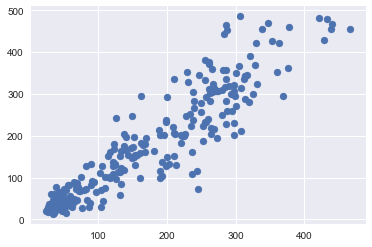

In [5]:
## Methane flux model
# CH4 model features
CH4_features = ['gpp_ANNnight', 'TA.y', 'VPD', 'PA.x', 'ustar']

# extract data features and y variable
X_ch4 = pre_rise[CH4_features]
Y_ch4 = pre_rise['wm_gf']

#train, test splits
Xtrain, Xtest, ytrain, ytest = train_test_split(X_ch4, Y_ch4, random_state=0)

#fit the model
grid.fit(Xtrain, ytrain)

# prediction against test case
CH4_forest = grid.best_estimator_
tCH4_out = CH4_forest.predict(Xtest)

plt.scatter(tCH4_out, ytest)
print("R2:", r2_score(tCH4_out, ytest))
print("RMSE:", mean_squared_error(tCH4_out, ytest))

R2: 0.482801010177
RMSE: 5.01516798542


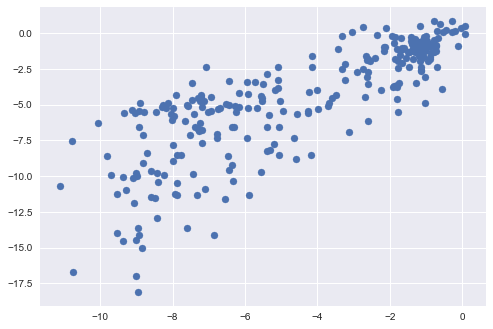

In [127]:
## GEP flux model
# CH4 model features
GEP_features = ['PAR', 'TA.y', 'VPD', 'PA.x', 'ustar']

# extract data features and y variable
X_co2 = pre_rise[GEP_features]
Y_co2 = pre_rise['gpp_ANNnight']

#train, test splits
Xtrain, Xtest, ytrain, ytest = train_test_split(X_co2, Y_co2)

#fit the model
grid.fit(Xtrain, ytrain)

# prediction against test case
GEP_forest = grid.best_estimator_
tGEP_out = GEP_forest.predict(Xtest)

plt.scatter(tGEP_out, ytest)
print("R2:", r2_score(tGEP_out, ytest))
print("RMSE:", mean_squared_error(tGEP_out, ytest))

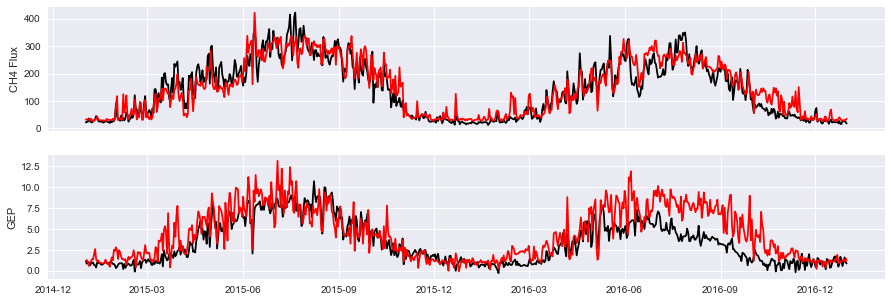

In [174]:
#final plot recreating Fig4

#salinity naive CH4 model predictions
XCH4_peak = peak_period[CH4_features]
peak_period['CH4_pred'] = CH4_forest.predict(XCH4_peak)

#salinity naive GEP model predictions
XGEP_peak = peak_period[GEP_features]
peak_period['GEP_pred'] = GEP_forest.predict(XGEP_peak)

#plot Fig4
fig, ax = plt.subplots(2, 1, figsize=(15, 5),
                      sharex='col')

ax[0].plot(peak_period['wm_gf'], color='black')
ax[0].plot(peak_period['CH4_pred'], color='red')
ax[0].set_ylabel('CH4 Flux')
ax[1].plot(peak_period['gpp_ANNnight']*-1, color='black')
ax[1].plot(peak_period['GEP_pred']*-1, color='red')
ax[1].set_ylabel('GEP');

In [195]:
#annual differences
annual = peak_period.resample('A').mean()

annual['CH4_reduction'] = (1 - annual['wm_gf'] / annual['CH4_pred']) * 100
annual['GEP_reduction'] = (1 - annual['gpp_ANNnight'] / annual['GEP_pred']) * 100

annual.head()

,wm_gf,gpp_ANNnight,TA.y,PAR,VPD,PA.x,ustar,CH4_pred,GEP_pred,CH4_reduction,GEP_reduction
datetime,,,,,,,,,,,
2015-12-31,159.698605,-3.977875,16.099424,472.785796,0.775397,101.596269,0.410001,158.612779,-4.445705,-0.684577,10.523177
2016-12-31,124.767697,-2.659409,15.805928,467.130763,0.728316,101.574188,0.404482,137.563765,-4.353153,9.301918,38.908447
